### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [81]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [82]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [83]:
# !pip install lightgbm

## LGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

In [84]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
# from DEV_Common_Data_Preprocessing import resample_by_last, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [85]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [86]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-12-01 18:38:30.019904
2023 / 12 / 1
18 : 38


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [87]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

str_region = "KANGNAM"
col_tar = "KANGNAM"

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + "KDHC_COMB_" + str_region + "HEATxWEATHER_2019-2022.csv", index_col = 0)
df_kdhc_heat

['DATA_KDHC_Heat_Provide_Cheongju_2010_2021.csv', 'DATA_KDHC_Heat_Provide_Cheongju_2010_2021_1st_Check.csv', 'DATA_KDHC_Heat_Provide_Sejong_2014_2018.csv', 'DATA_KDHC_Heat_Provide_Sejong_2014_2018_1st_Check.csv', 'DATA_KDHC_Heat_Sell_Branch_201910_202109.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']


,METER_DATE,day_of_the_week_x,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,day_of_the_week_y,rest_YN,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,KANGNAM
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,Tuesday,0,...,0.0000000000,19.5000000000,1013.2000000000,1017.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,455.0000000000,61.3000000000
1,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,Tuesday,0,...,0.0000000000,19.5000000000,1013.2000000000,1017.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,455.0000000000,61.3000000000
2,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,Tuesday,0,...,320.0000000000,19.4000000000,1013.1000000000,1017.8000000000,0.0000000000,0.0000000000,2.0000000000,0.0000000000,336.0000000000,61.3000000000
3,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,Tuesday,0,...,320.0000000000,19.4000000000,1013.1000000000,1017.8000000000,0.0000000000,0.0000000000,2.0000000000,0.0000000000,336.0000000000,61.3000000000
4,2019-10-01 03:00:00,Tuesday,2019,10,1,3,0,1,Tuesday,0,...,0.0000000000,18.5000000000,1013.0000000000,1017.7000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,391.0000000000,56.3000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4,Friday,0,...,250.0000000000,19.7000000000,1011.9000000000,1016.5000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,320.0000000000,120.0000000000
27299,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4,Friday,0,...,250.0000000000,19.9000000000,1012.2000000000,1016.9000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,257.0000000000,112.0000000000
27300,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4,Friday,0,...,250.0000000000,19.6000000000,1012.4000000000,1017.1000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,277.0000000000,95.0000000000
27301,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4,Friday,0,...,230.0000000000,19.4000000000,1012.4000000000,1017.1000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,237.0000000000,89.0000000000


In [88]:
for i in range(0, len(df_kdhc_heat)):
    if df_kdhc_heat['rest_YN'].iloc[i] == 'N':
        df_kdhc_heat['rest_YN'].iloc[i] = 0
    elif df_kdhc_heat['rest_YN'].iloc[i] == 'Y':
        df_kdhc_heat['rest_YN'].iloc[i] = 1
df_kdhc_heat['rest_YN'] = df_kdhc_heat['rest_YN'].astype(int)

for i in range(0, len(df_kdhc_heat)):
    if df_kdhc_heat['dist_from_holiday'].iloc[i] == '제헌절':
        df_kdhc_heat['dist_from_holiday'].iloc[i] = 0
    # elif df_kdhc_heat['rest_YN'].iloc[i] == 'Y':
        # df_kdhc_heat['rest_YN'].iloc[i] = 1

df_kdhc_heat['dist_from_holiday'] = df_kdhc_heat['dist_from_holiday'].astype(int)

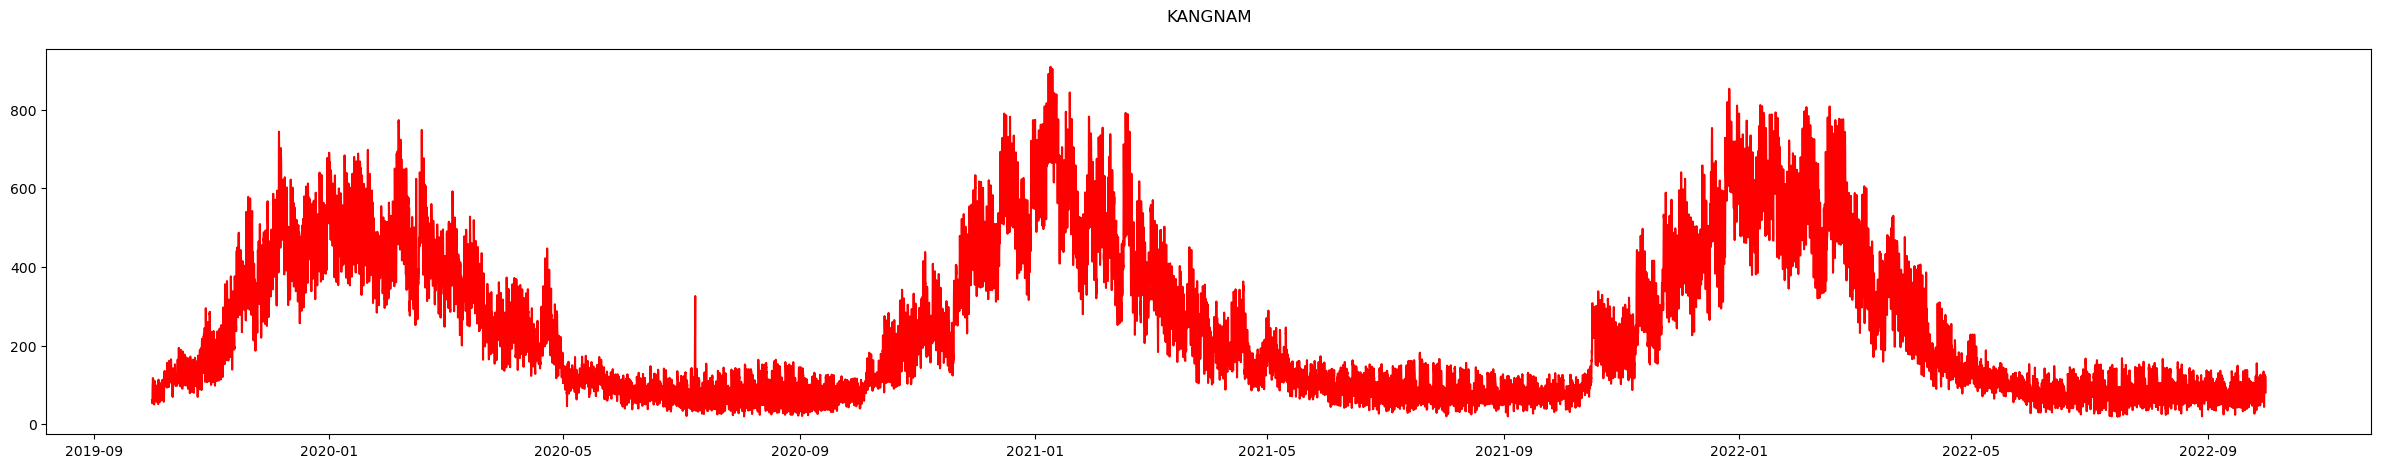

In [89]:
df_kdhc_heat = df_kdhc_heat[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday'
                             , 'HOUR'
                             , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                             , 'humidity'
                             , 'rainfall', 'snowfall', 'snowfall_3hr'
                             , 'wind_speed', 'wind_direction'
                             , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                             , 'sunshine', 'solar_radiation'
                             , 'cloud_total', 'cloud_midlow'
                             , 'visual_range'
                             , col_tar]]
visualization_df(df_kdhc_heat, col_tar)

In [90]:
df_kdhc_heat_WD = df_kdhc_heat[df_kdhc_heat['rest_YN'] == 0]
print(df_kdhc_heat_WD.shape)
df_kdhc_heat_WE = df_kdhc_heat[df_kdhc_heat['rest_YN'] == 1]
print(df_kdhc_heat_WE.shape)

(18566, 26)
(8737, 26)


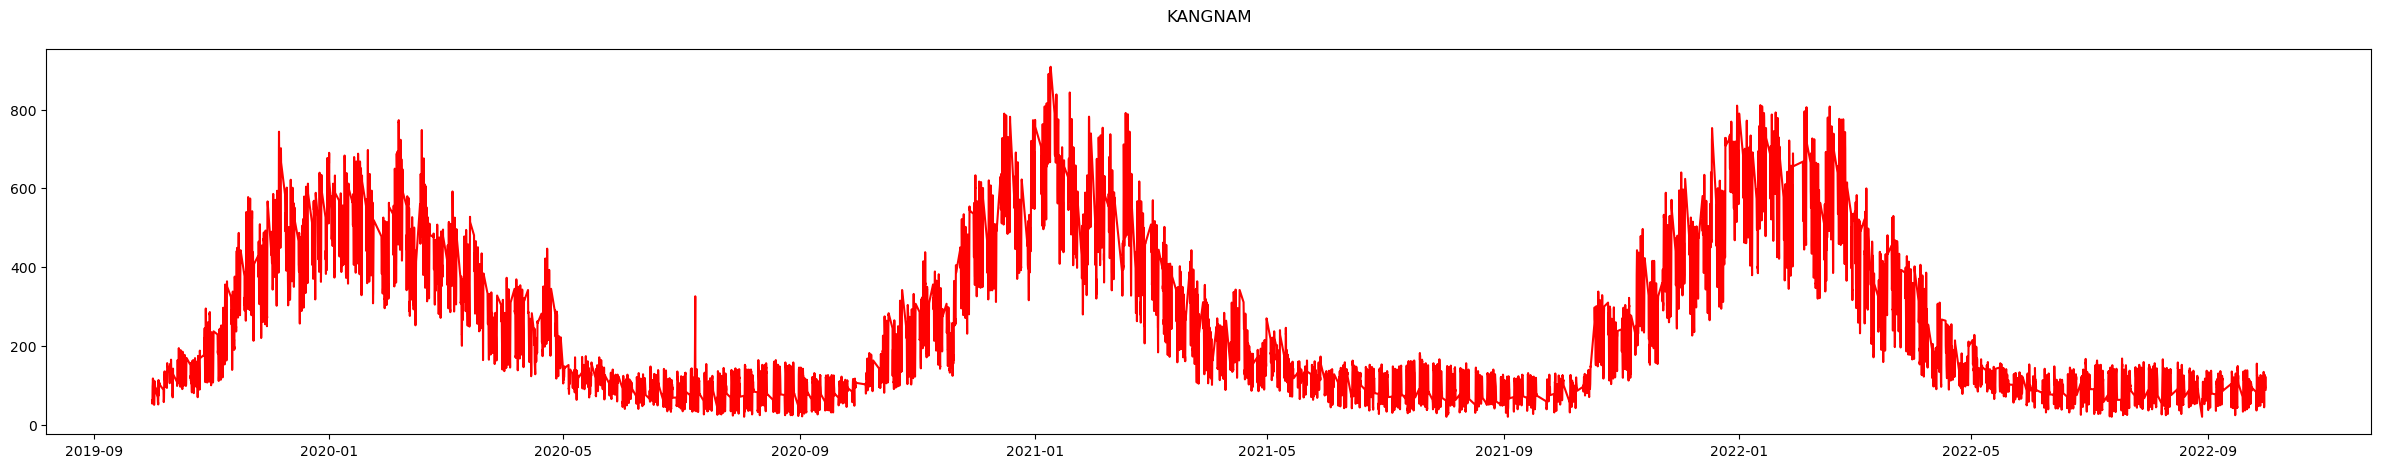

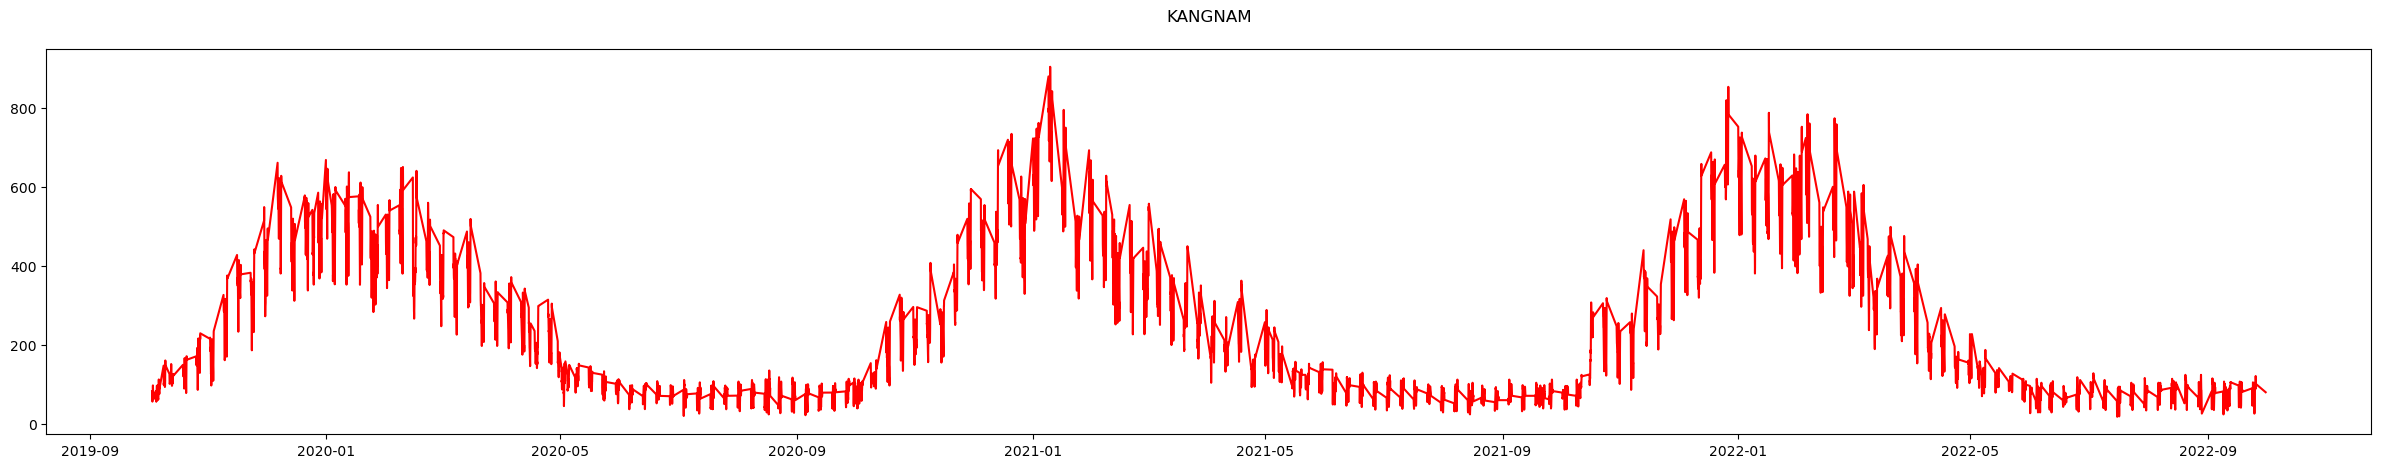

In [91]:
visualization_df(df_kdhc_heat_WD, col_tar)
visualization_df(df_kdhc_heat_WE, col_tar)

In [92]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_kdhc_heat_WD.corr()
df_corr.corr()

,YEAR,MONTH,DAY,code_day_of_the_week,rest_YN,dist_from_holiday,HOUR,temp_outdoor,temp_dew_point,temp_ground,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,KANGNAM
YEAR,1.0000000000,-0.5468213173,0.0248561365,0.0161363528,NaN,0.0183210101,0.0466723471,0.2674524340,0.2061312579,0.2851444703,...,-0.0474143221,0.2343806299,-0.3371075884,-0.3357316012,0.0644136757,0.1741959894,0.1473159190,0.1005482093,0.0899001740,-0.2162399571
MONTH,-0.5468213173,1.0000000000,-0.0215082659,0.0031800664,NaN,-0.0200323457,-0.0798594976,0.3926283339,0.4387248907,0.3452324870,...,-0.2601394637,0.4162507716,-0.2799282172,-0.2830654666,-0.1467949403,-0.0969055905,0.2270022675,0.1901741971,-0.1656892802,-0.4525353922
DAY,0.0248561365,-0.0215082659,1.0000000000,-0.0159809047,NaN,0.0152976606,-0.0655740940,0.0142110911,0.0301770919,-0.0030922690,...,-0.1194730393,0.0141450860,-0.0559126059,-0.0549862191,-0.0957199201,-0.0818436193,0.0458850547,0.0354361862,-0.0708568705,-0.0344632026
code_day_of_the_week,0.0161363528,0.0031800664,-0.0159809047,1.0000000000,NaN,-0.9957059761,0.0098840769,0.0287272006,0.0109494730,0.0275170063,...,-0.0152605887,0.0150852108,-0.0063771571,-0.0069018088,0.0265989831,0.0305415654,-0.0165097638,-0.0174196050,0.0325771680,-0.0249556085
rest_YN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dist_from_holiday,0.0183210101,-0.0200323457,0.0152976606,-0.9957059761,NaN,1.0000000000,-0.0185451872,-0.0118635180,0.0062075886,-0.0125713006,...,0.0032241927,0.0030124123,-0.0164004023,-0.0157589099,-0.0388703163,-0.0363208356,0.0334920669,0.0316556105,-0.0367679794,0.0083587194
HOUR,0.0466723471,-0.0798594976,-0.0655740940,0.0098840769,NaN,-0.0185451872,1.0000000000,0.1045069502,-0.0604954230,0.1551192125,...,0.4167374144,-0.0577237447,-0.0181757101,-0.0201840341,0.4296764514,0.4257334802,-0.2020395577,-0.2518955324,0.4929194335,-0.0067260237
temp_outdoor,0.2674524340,0.3926283339,0.0142110911,0.0287272006,NaN,-0.0118635180,0.1045069502,1.0000000000,0.9610255986,0.9883274039,...,-0.3249315591,0.9605246470,-0.9510658172,-0.9533343863,0.0448928699,0.3122230052,0.6244124515,0.5092342031,-0.0936112682,-0.9901693315
temp_dew_point,0.2061312579,0.4387248907,0.0301770919,0.0109494730,NaN,0.0062075886,-0.0604954230,0.9610255986,1.0000000000,0.9135661269,...,-0.4538860418,0.9981060983,-0.9631094054,-0.9642072025,-0.2070948385,0.0596573287,0.7451905123,0.6459045588,-0.3228826313,-0.9753854431
temp_ground,0.2851444703,0.3452324870,-0.0030922690,0.0275170063,NaN,-0.0125713006,0.1551192125,0.9883274039,0.9135661269,1.0000000000,...,-0.2465624133,0.9138094916,-0.9191259143,-0.9218210245,0.1886805483,0.4502240514,0.5384310918,0.4224436098,-0.0007751355,-0.9673159694


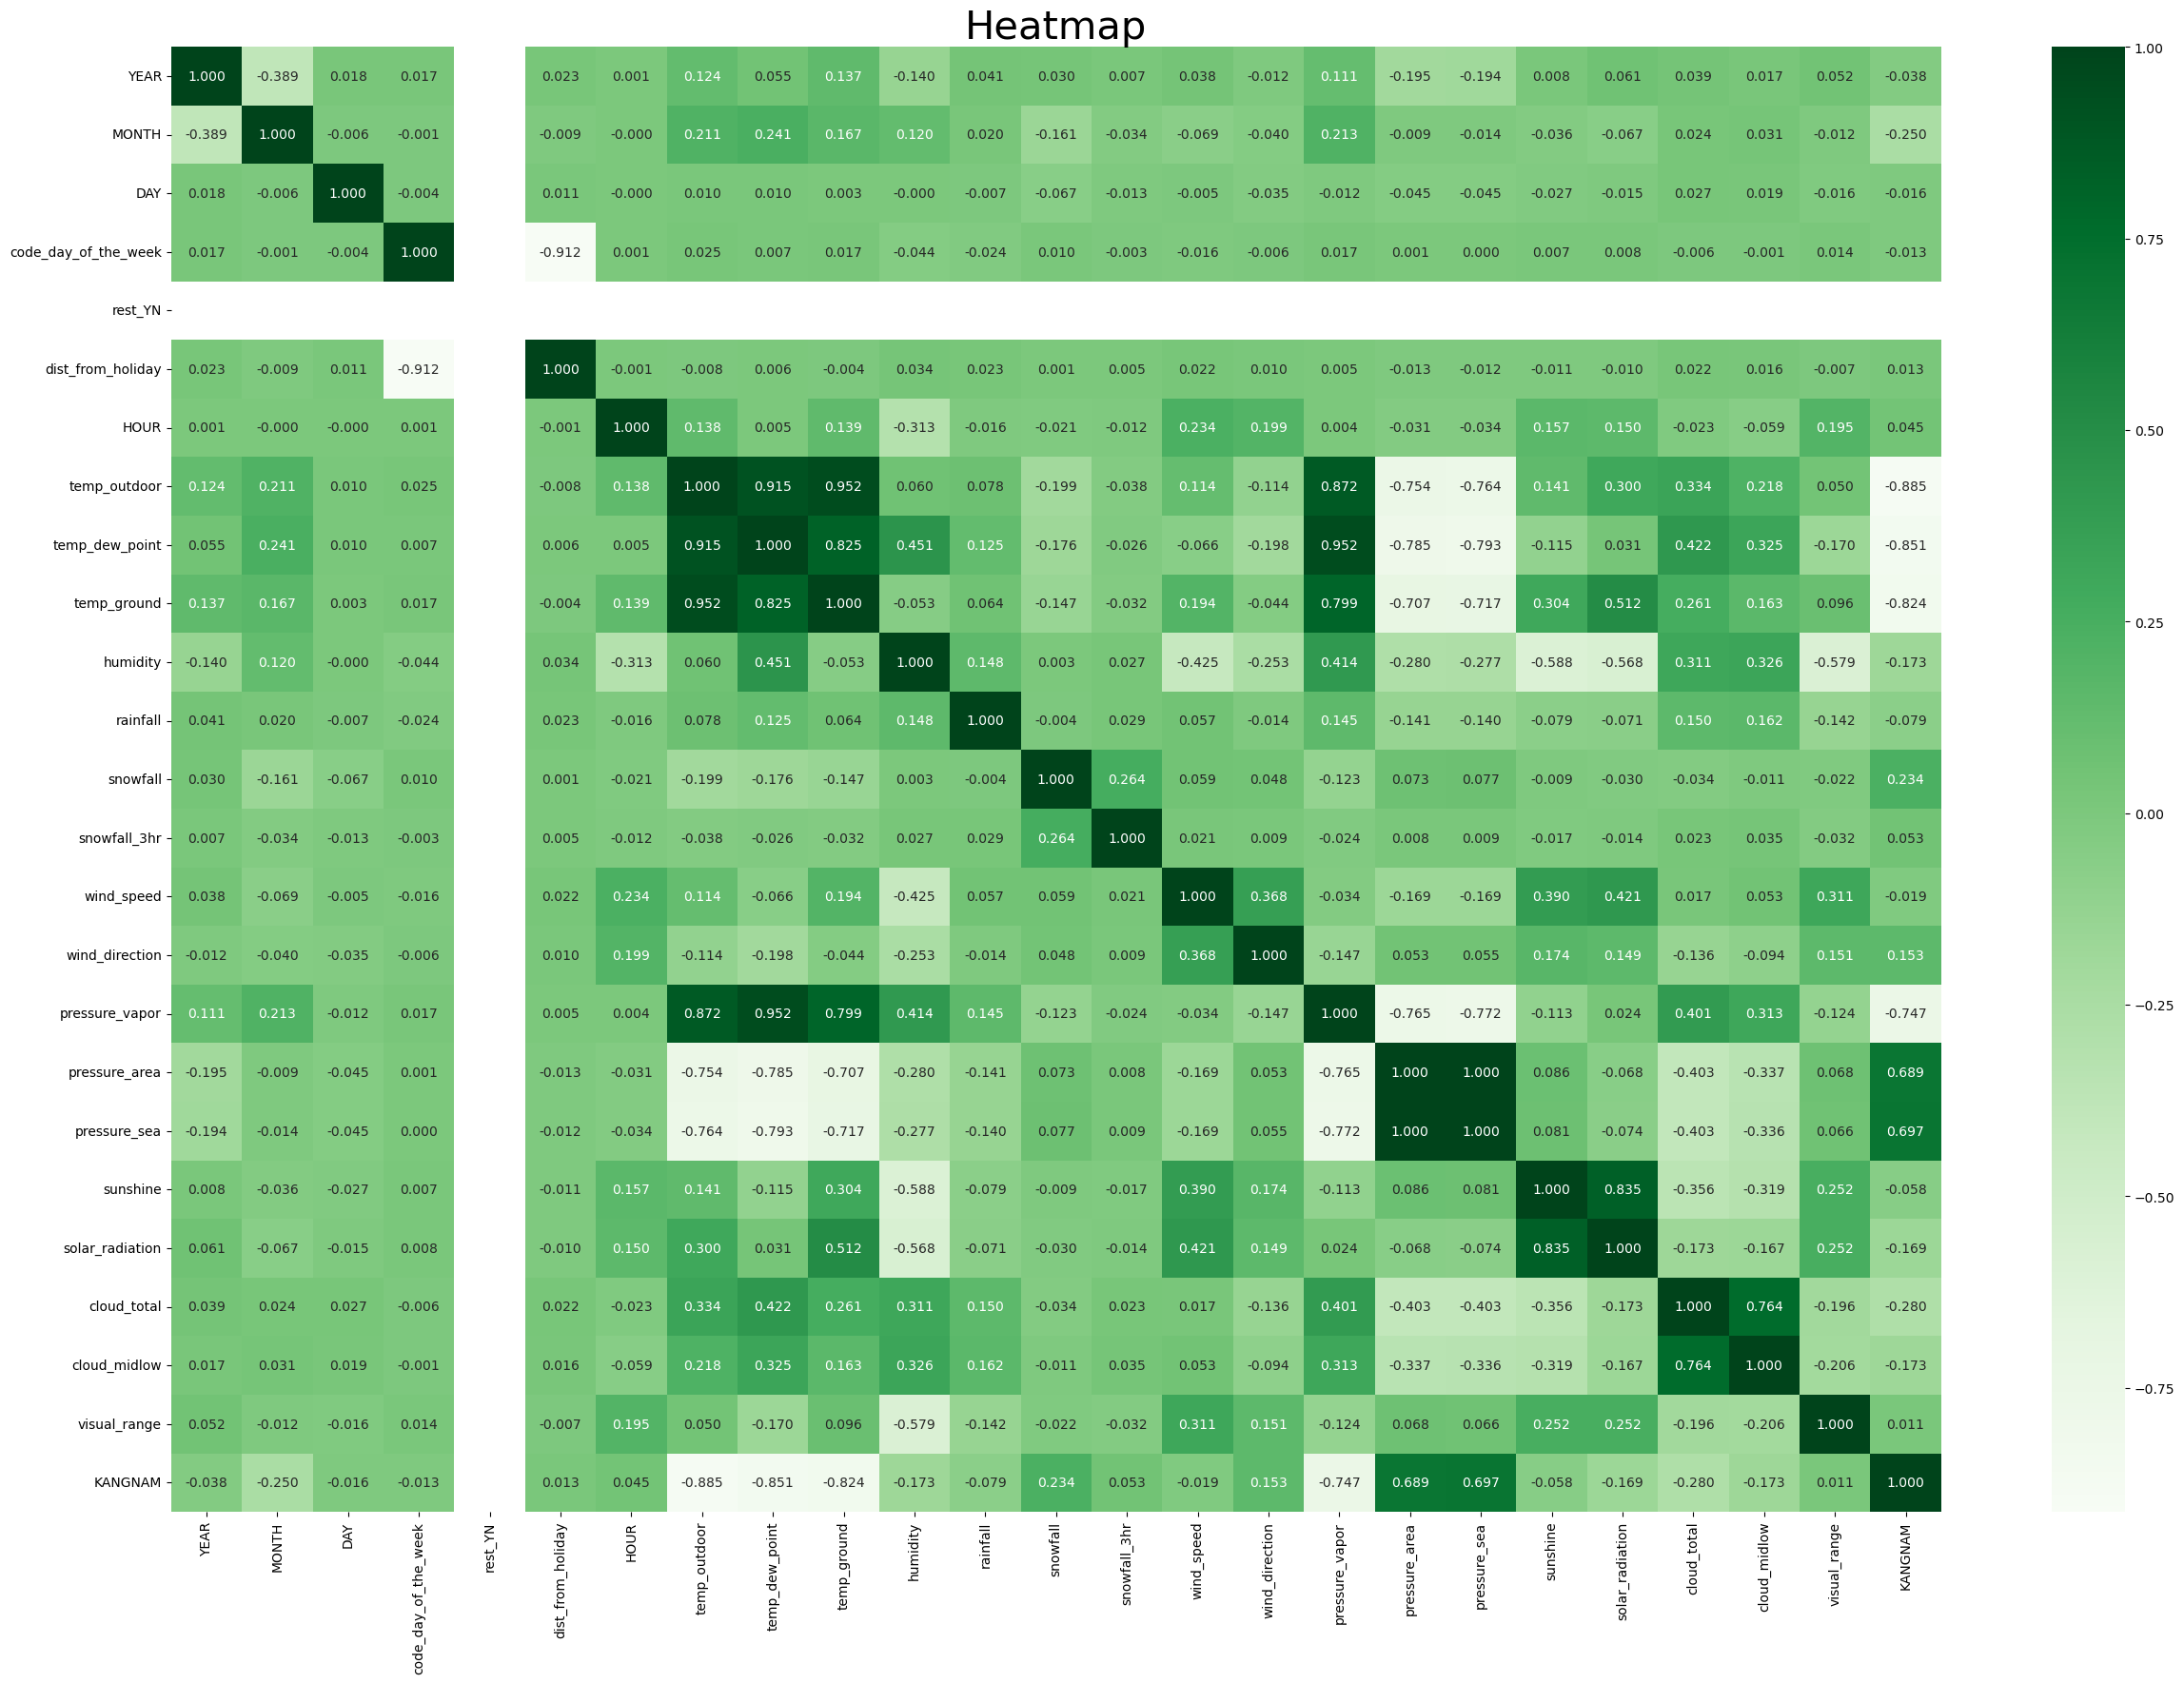

In [93]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap", fontsize=30)
plt.show()

In [94]:
df_kdhc_heat_WD = df_kdhc_heat_WD.drop(["METER_DATE"], axis = 1)

X = df_kdhc_heat_WD.drop([col_tar], axis=1)
Y = df_kdhc_heat_WD[[col_tar]]

In [95]:
trainSet, testSet = train_test_split(df_kdhc_heat_WD, test_size=0.3, shuffle=False)
print(trainSet.shape, testSet.shape)

(12996, 25) (5570, 25)


In [96]:
trainXX = trainSet.drop([col_tar],axis=1)
trainYY = trainSet[[col_tar]]

testXX = testSet.drop([col_tar],axis=1)
testYY = testSet[[col_tar]]

In [97]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = LGBMRegressor(n_estimators=10000, learning_rate=0.01, verbose=500) #10000

lgbm_model = model.fit(trainXX, trainYY, eval_metric='mae',eval_set=[(trainXX, trainYY)])

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.889120
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.228060
[LightGBM] [Debug] init for col-wise cost 0.000450 seconds, init for row-wise cost 0.000321 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2453
[LightGBM] [Info] Number of data points in the train set: 12996, number of used features: 23
[LightGBM] [Info] Start training from score 240.502539
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a t

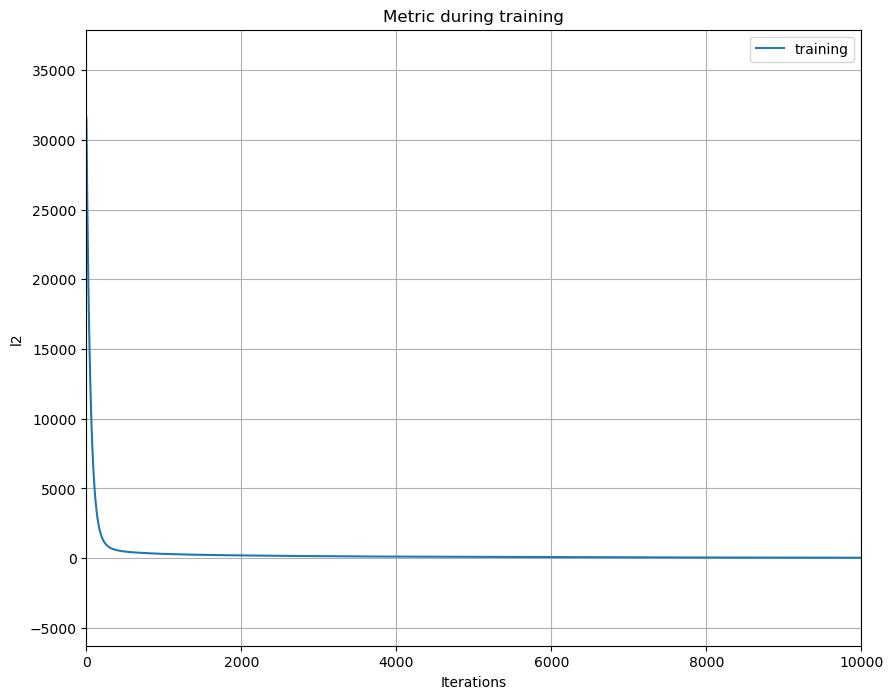

In [98]:
lgbm.plot_metric(lgbm_model)
plt.show()

In [99]:
model_pred = model.predict(testXX)
model_preds=np.reshape(model_pred,(-1,1))

d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

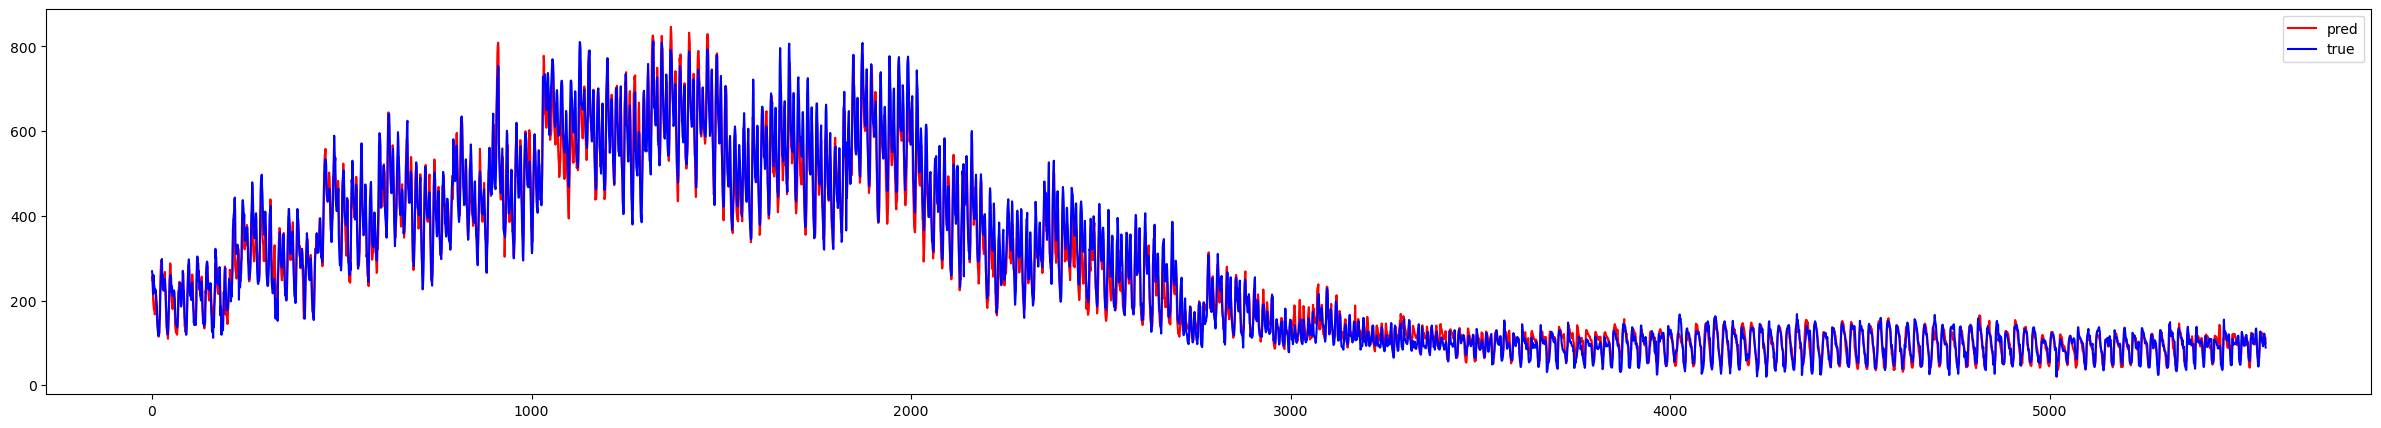

In [100]:
plt.figure(figsize=(30,5))
plt.plot(model_preds,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, model_preds))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, model_preds))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, model_preds))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, model_preds))

mean_absolute_percentage_error :  0.11071706048826878
mean_absolute_error :  20.673079243352458
mean_squared_error :  820.4635523662641
r2_score :  0.9798654164965758


### 주말

In [102]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_kdhc_heat_WE.corr()
df_corr.corr()

,YEAR,MONTH,DAY,code_day_of_the_week,rest_YN,dist_from_holiday,HOUR,temp_outdoor,temp_dew_point,temp_ground,...,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,KANGNAM
YEAR,1.0000000000,-0.5568564475,-0.0198610118,-0.1362596501,NaN,NaN,0.0799134625,0.2074585984,0.1278809590,0.2300812649,...,0.1381714145,0.1615711392,-0.2913776102,-0.2896066239,0.1277668089,0.2146560804,0.0821634470,0.0617856820,0.1466410729,-0.1415234441
MONTH,-0.5568564475,1.0000000000,-0.0342503046,-0.0107134248,NaN,NaN,-0.0667831069,0.4656973538,0.4984489178,0.4233639165,...,-0.3551735341,0.4758785804,-0.3116005949,-0.3157944139,-0.0989783328,-0.0368339525,0.2048887397,0.1255228760,0.0239598838,-0.5315239950
DAY,-0.0198610118,-0.0342503046,1.0000000000,0.1804746821,NaN,NaN,-0.0359428020,-0.0460195876,-0.0664975551,-0.0419446757,...,-0.0050866052,-0.0725473341,0.0518654405,0.0518248230,0.0708432711,0.0332805220,-0.1763903627,-0.1928948362,0.0996757330,0.0379687418
code_day_of_the_week,-0.1362596501,-0.0107134248,0.1804746821,1.0000000000,NaN,NaN,-0.0781221338,-0.1325578874,-0.1213621199,-0.1352892663,...,-0.0425494960,-0.1279131376,0.1206238619,0.1210424827,-0.0155058458,-0.0597690564,-0.1606433189,-0.1472139571,-0.1095545041,0.1133677781
rest_YN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dist_from_holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUR,0.0799134625,-0.0667831069,-0.0359428020,-0.0781221338,NaN,NaN,1.0000000000,0.1402914228,-0.0183877595,0.1863693115,...,0.3744822742,-0.0200045593,-0.0522731141,-0.0543158563,0.4265033945,0.4184031015,-0.1894260165,-0.2445377536,0.4774200198,-0.0375856441
temp_outdoor,0.2074585984,0.4656973538,-0.0460195876,-0.1325578874,NaN,NaN,0.1402914228,1.0000000000,0.9581701583,0.9888204529,...,-0.2181715325,0.9569761490,-0.9448210496,-0.9473442411,0.1283731398,0.3655387091,0.5336756240,0.4103659288,0.1197032249,-0.9894473111
temp_dew_point,0.1278809590,0.4984489178,-0.0664975551,-0.1213621199,NaN,NaN,-0.0183877595,0.9581701583,1.0000000000,0.9110974009,...,-0.3521298969,0.9981862926,-0.9614743698,-0.9626777728,-0.1342557758,0.1077733242,0.6764409000,0.5697270836,-0.1271360076,-0.9767631795
temp_ground,0.2300812649,0.4233639165,-0.0419446757,-0.1352892663,NaN,NaN,0.1863693115,0.9888204529,0.9110974009,1.0000000000,...,-0.1417800195,0.9096790546,-0.9131039301,-0.9160501924,0.2668772859,0.4974917911,0.4471123181,0.3244509556,0.2046740500,-0.9653711481


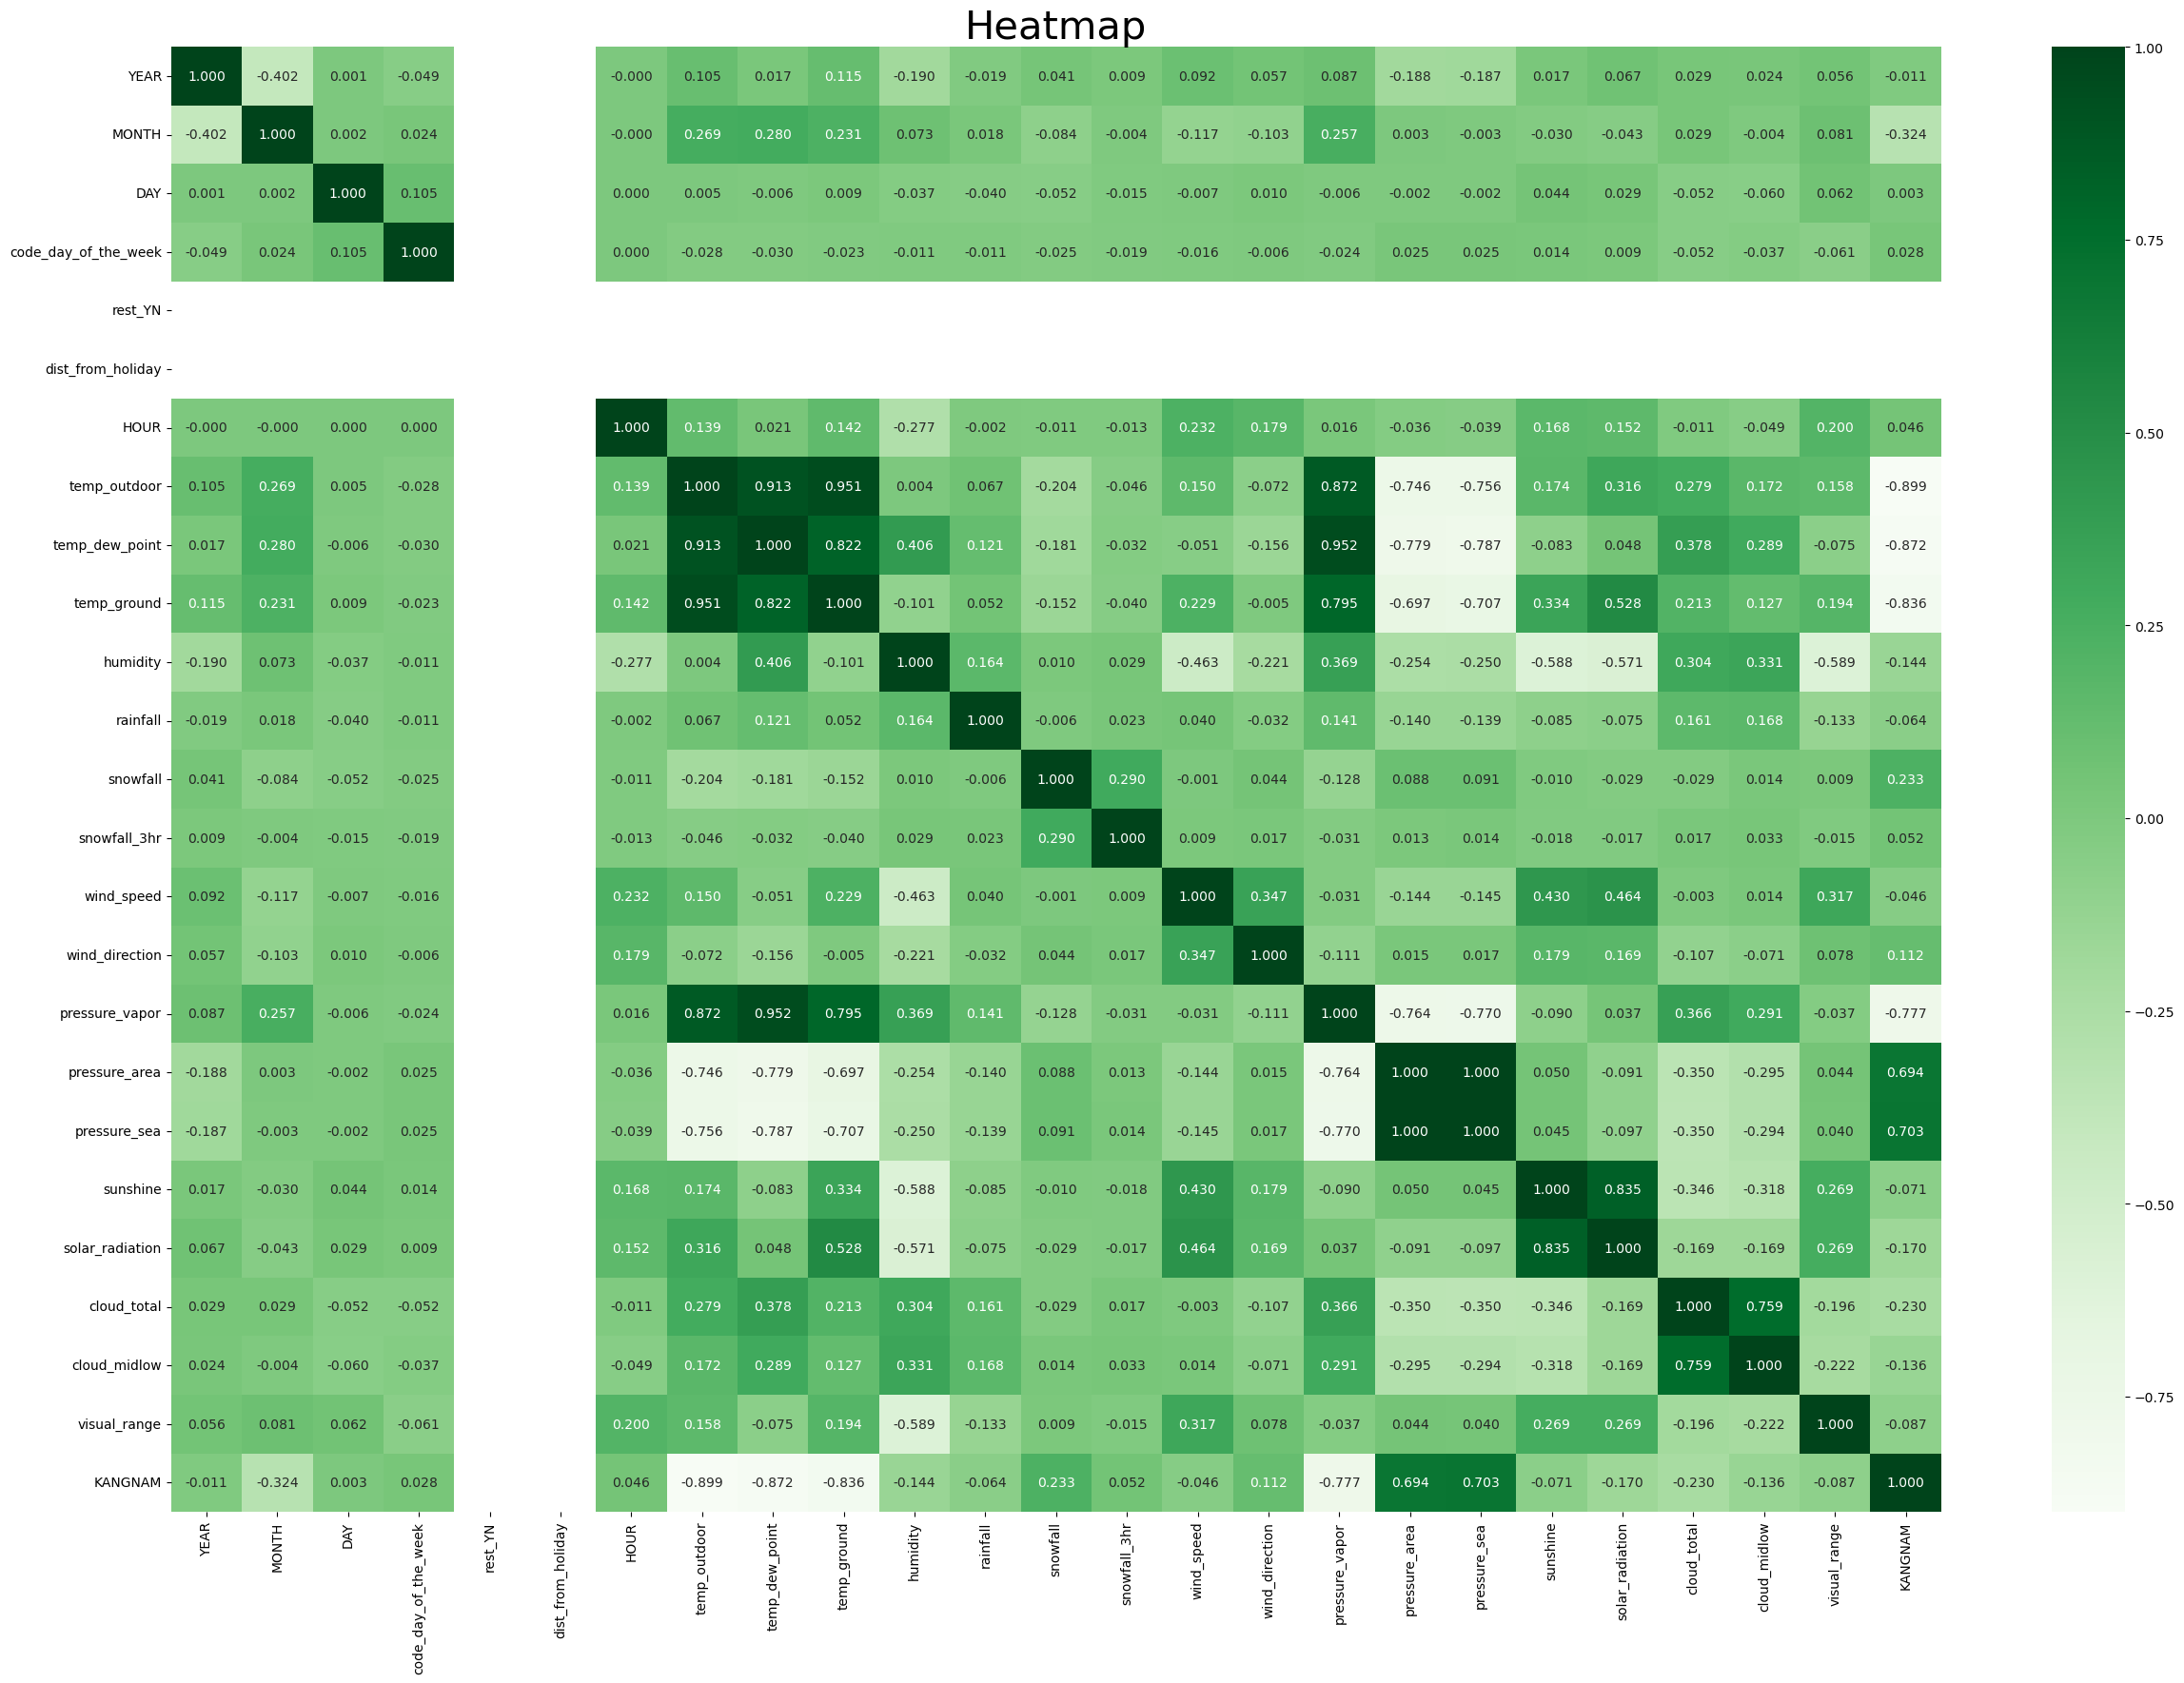

In [103]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap", fontsize=30)
plt.show()

In [104]:
df_kdhc_heat_WE = df_kdhc_heat_WE.drop(["METER_DATE"], axis = 1)

X = df_kdhc_heat_WE.drop([col_tar], axis=1)
Y = df_kdhc_heat_WE[[col_tar]]

In [105]:
trainSet, testSet = train_test_split(df_kdhc_heat_WE, test_size=0.3, shuffle=False)
print(trainSet.shape, testSet.shape)

(6115, 25) (2622, 25)


In [106]:
trainXX = trainSet.drop([col_tar],axis=1)
trainYY = trainSet[[col_tar]]

testXX = testSet.drop([col_tar],axis=1)
testYY = testSet[[col_tar]]

In [107]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = LGBMRegressor(n_estimators=10000, learning_rate=0.01, verbose=500) #10000

lgbm_model = model.fit(trainXX, trainYY, eval_metric='mae',eval_set=[(trainXX, trainYY)])

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.857890
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193459
[LightGBM] [Debug] init for col-wise cost 0.000324 seconds, init for row-wise cost 0.000304 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2377
[LightGBM] [Info] Number of data points in the train set: 6115, number of used features: 21
[LightGBM] [Info] Start training from score 226.455062
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM]

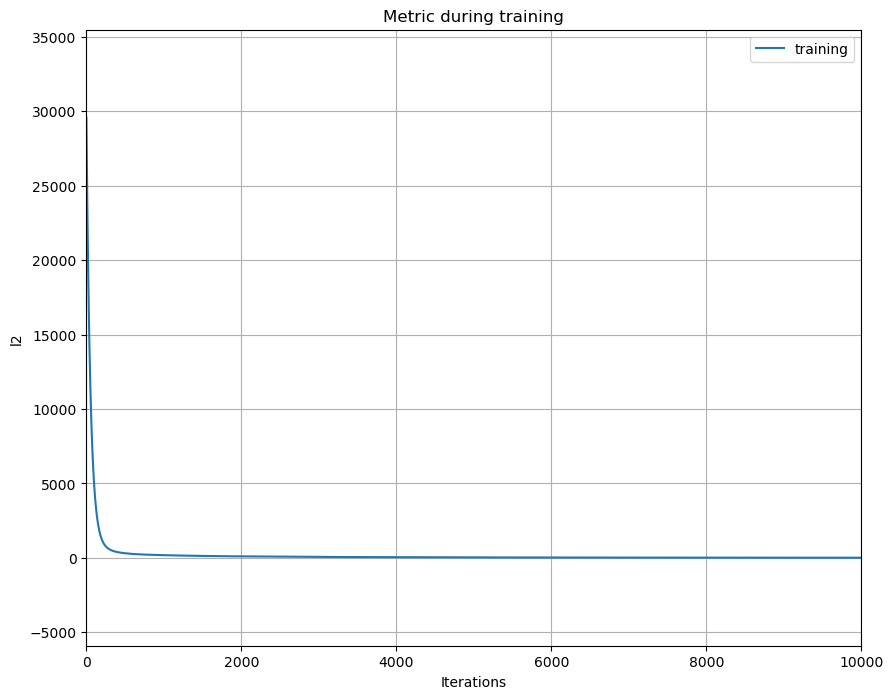

In [108]:
lgbm.plot_metric(lgbm_model)
plt.show()

In [109]:
model_pred = model.predict(testXX)
model_preds=np.reshape(model_pred,(-1,1))

d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

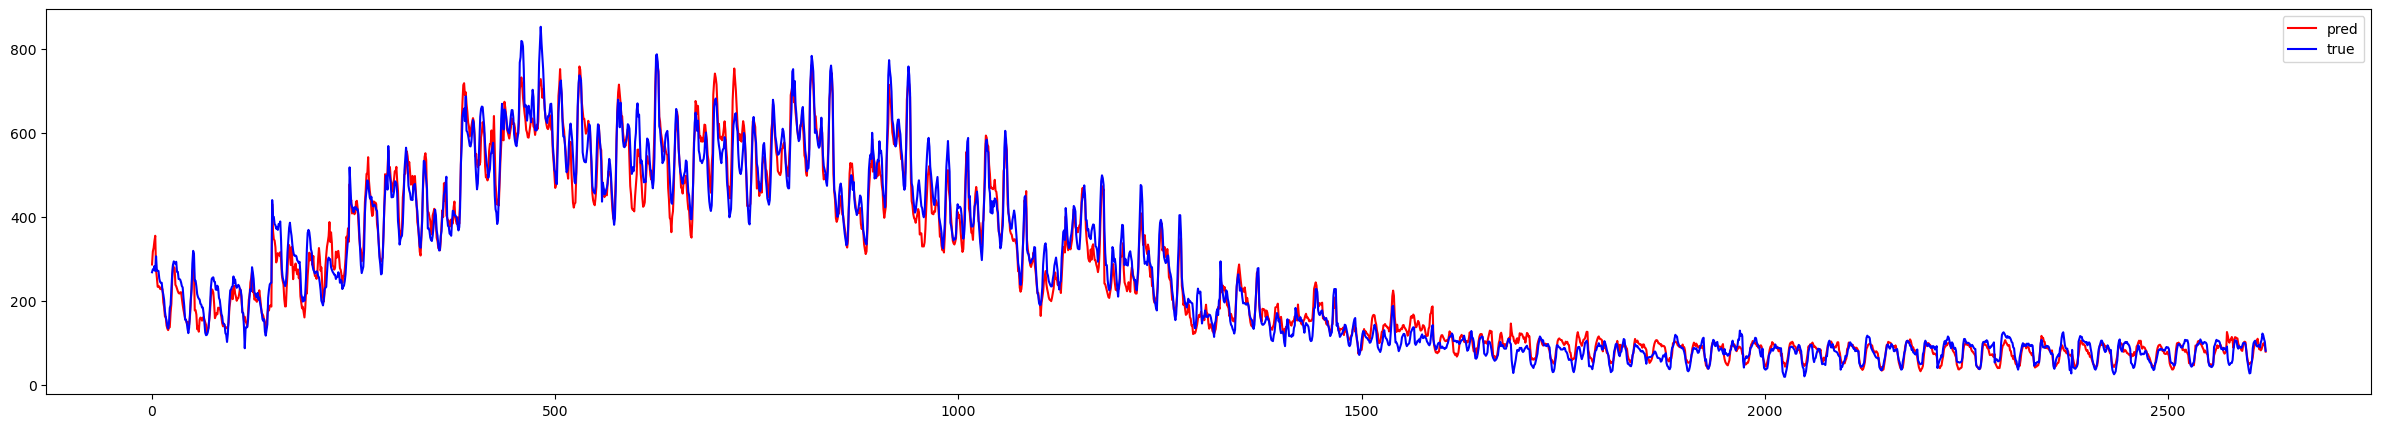

In [110]:
plt.figure(figsize=(30,5))
plt.plot(model_preds,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [111]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, model_preds))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, model_preds))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, model_preds))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, model_preds))

mean_absolute_percentage_error :  0.13515248825859386
mean_absolute_error :  23.258160761285097
mean_squared_error :  991.8206406205129
r2_score :  0.9755481165621988
